In [1]:
import sys
import importlib
import torch
from torchvision import datasets, transforms

from attrdict import AttrDict
import numpy as np

sys.path.append('..')

import src.utils
importlib.reload(src.utils)



In IPython Kernel
In IPython Kernel
In IPython Kernel


/Users/david/workspace/normalizing_flows/maf.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/david/.pyenv/versions/3.6.1/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/david/.pyenv/versions/3.6.1/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/david/.ve/mce/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/david/.ve/mce/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/david/.ve/mce/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    sel

<module 'src.utils' from '/Users/david/workspace/mce/src/utils.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') 

In [3]:
%load_ext autoreload 
%autoreload 2

In [4]:
outdir = '../out/mnist/'
modeldir = '../models/mnist/'

# Just needed for data loading, really
args = AttrDict({'batch_size': 256,
                 'lr': 0.001,
                 'momentum': 0.5,
                 'epochs': 10,
                 'log_interval': 10,
                 'device': torch.device('cpu')})

# Reproducibility
np.random.seed(2018)

In [6]:
## My previous way of loafing

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=False)


# ## Maf loading

sys.path.append('/Users/david/workspace/normalizing_flows/')
root = '../data/'
import datasets as maf_datasets
#print(datasets.root)
maf_datasets.root = '/Users/david/workspace/normalizing_flows/data/'
from data import fetch_dataloaders
from datasets.mnist import MNIST
train_loader, test_loader = fetch_dataloaders('MNIST', args.batch_size, args.device, False)

In [7]:
import torchvision.transforms as T
lam = 1e-6
from src.woe_utils import logit, invlogit
maf_transform = T.Compose([
                              #T.ToTensor(),
                              #T.Lambda(lambda x: x + torch.rand(*x.shape) / 256.),    # dequantize (cf MAF paper)
                              T.Lambda(lambda x: logit(lam + (1 - 2 * lam) * x))])   



sigma = 5e-2
mce_to_maf_transform = T.Compose([
                                  T.Lambda(lambda x: x*(.3081) + .1307),
                                  T.Lambda(lambda x: x + sigma*torch.rand(*x.shape) / 256.0),    # dequantize (cf MAF paper)    
                                  T.Lambda(lambda x: logit(lam + (1 - 2 * lam) * x))
                                ]) 

maf_to_mce_transform = T.Compose([
                                  T.Lambda(lambda x: (invlogit(x) - lam)/(1 - 2 * lam)),
                                  T.Normalize((0.1307,), (0.3081,))
    ]) 




tensor(-12.1167) tensor(5.5097)
tensor(-12.1167) tensor(5.5097)
tensor(-11.5129) tensor(11.5116)


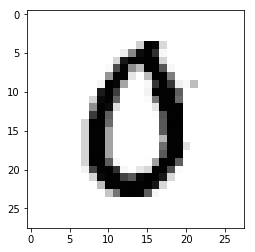

In [8]:
# # Grab a batch for experiments
batch_x, batch_y = next(iter(train_loader))
idx = 2
plt.imshow(maf_to_mce_transform(batch_x[idx].reshape(1,28,28)).squeeze(), cmap = 'Greys')

print(batch_x[0].min(), batch_x[0].max())
bbx = mce_to_maf_transform(batch_x)
print(batch_x[0].min(), batch_x[0].max())
print(bbx[0].min(), bbx[0].max())



### Doing inside woe_model now
# batch_x = mce_to_maf_transform(batch_x)
# print(batch_x.min(), batch_x.max())
# plt.imshow(batch_x[idx].squeeze(), cmap = 'Greys')

### Load Classifier

In [9]:
from src.models import image_classifier

classifier = torch.load(os.path.join(modeldir, "classif.pth"))

In [10]:
from src.woe_utils import restore_model_from_file, woe_maf

importlib.reload(src.woe_utils)

### Load WOE Model

n_blocks = 5
n_hidden = 2
hidden_size = 1024
typ = 'fwd'



#B5_H2_128_lr1e-5

woe_model_dir = '/Users/david/workspace/normalizing_flows/results/maf/'

model_A_dir  = os.path.join(woe_model_dir, 'blocks_{}/B{}_H{}_{}'.format(typ, n_blocks, n_hidden, hidden_size))
maf_model, args = restore_model_from_file(os.path.join(model_A_dir, 'best_model_checkpoint.pt'))

woe_model = woe_maf(maf_model, 'mnist', range(10), (28*28))
#woe_model.data_transform = mce_to_maf_transform
print('')

Saved model doesnt have args
AttrDict({'dataset': 'MNIST', 'model': 'maf', 'flip_toy_var_order': False, 'input_size': 784, 'input_dims': (1, 28, 28), 'cond_label_size': 10, 'activation_fn': 'relu', 'conditional': True, 'no_batch_norm': False, 'batch_size': 100, 'lr': 0.0001, 'n_blocks': 5, 'n_hidden': 2, 'hidden_size': 1024, 'input_order': 'blocks', 'device': device(type='cpu')})
Loaded model from epoch 48 succesfully



In [12]:
#x  = batch_x[idx:idx+1]
from src.woe_utils import int2hot
# 12, 25, 30
idx = 0
x  = batch_x[idx:idx+1]
print(batch_x.shape)
print(x.min(), x.max())
woe_model._stop_caching()
#woe_model.model.forward(x.view(1,784), int2hot(2, 10))[0]
#woe_model.model.forward(mce_to_maf_transform(x.view(1,784)), int2hot(2, 10))[0]

torch.Size([256, 784])
tensor(-12.1167) tensor(5.5097)


In [13]:
print(outdir)

../out/mnist/


In IPython Kernel
In IPython Kernel


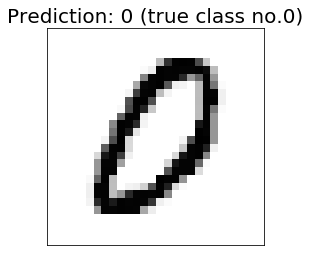


NOTE: For each step, we display only attributes with WOE > 5 (Positive Evidence)
or < -5 (Negative Evidence, if any such exist), up to at most five attributes per step.

--------------------
Explanation step:  0
Optimal score: 72.818115234375
Contrasting hypotheses: [0, 8, 6, 9]/[1, 2, 3, 4, 5, 7]
Total WoE: 73.60 (73.599365234375)
Positive Evidence:


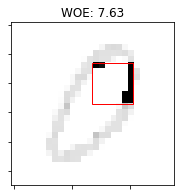


--------------------
Explanation step:  1
Optimal score: 54.3743896484375
Contrasting hypotheses: [0, 9]/[8, 6]
Total WoE: 66.87 (66.8743896484375)
Positive Evidence:


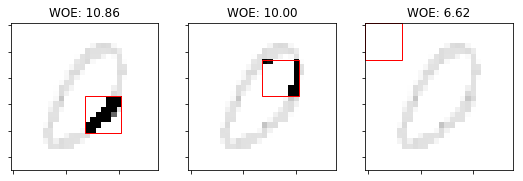


--------------------
Explanation step:  2
Contrasting hypotheses: [0]/[9]
Total WoE: 62.94 (62.9384765625)
Positive Evidence:


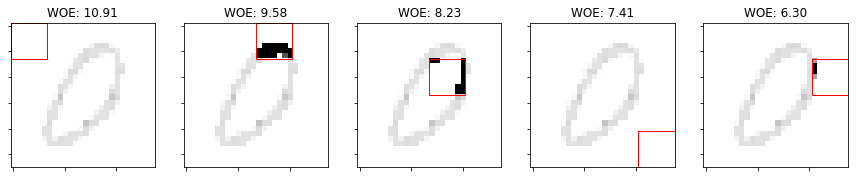

Done!


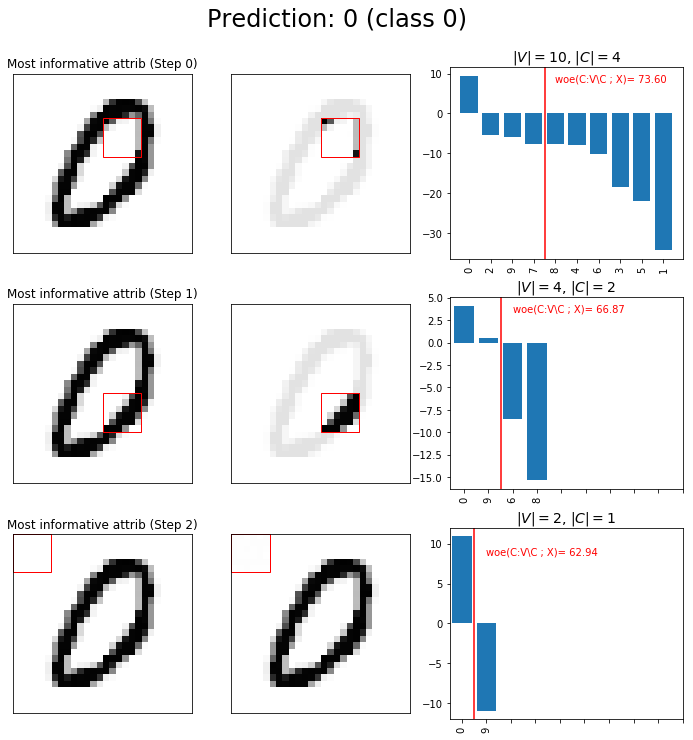

In [14]:
import src.explainers
importlib.reload(src.explainers)
from src.explainers import WOE_Explainer
import src.utils
importlib.reload(src.utils)

task = 'mnist'
classes = [str(i) for i in range(10)]
alpha = 50 
p = 2


Exp = WOE_Explainer(task,
                  (28,28),
                  classifier,
                  woe_model,
                  classes = classes,
                  loss_type = 'norm_delta',
                  alpha = alpha,
                  p     = p,
                  plot_type = 'treemap')


# 12, 25, 30
idx = 12
x  = batch_x[idx:idx+1]
#print(classes[batch_y[idx].item()])

fx = classifier(x.view(-1,1,28,28))
p, pred = fx.max(1)

# plt.imshow(invlogit(x.view(1,28,28)).squeeze(), cmap='Greys')
# plt.title('Prediction: ' + classes[pred] + ' (class no.{})'.format(pred.item()), fontsize = 20)
# plt.xticks([])
# plt.yticks([])
# plt.show()


e = Exp.explain(x.view(-1,1,28,28), pred.item(), verbose = 0 , show_plot = 2)
save_path = None
save_path = os.path.join(outdir, 'expl_woe_id-{}_alpha-{}.pdf'.format(idx, alpha, p))
# HAcky - find a better way to do this
e.input = invlogit(e.input)
e.plot(plot_type = 'bar', mask_alpha = 0.2, save_path = save_path)



IllegalArgumentException: RobustDeterminant encountered non-finite numbers 


PredicateError: Failed to evaluate <_FuncPtr object at 0x11f25cc00>

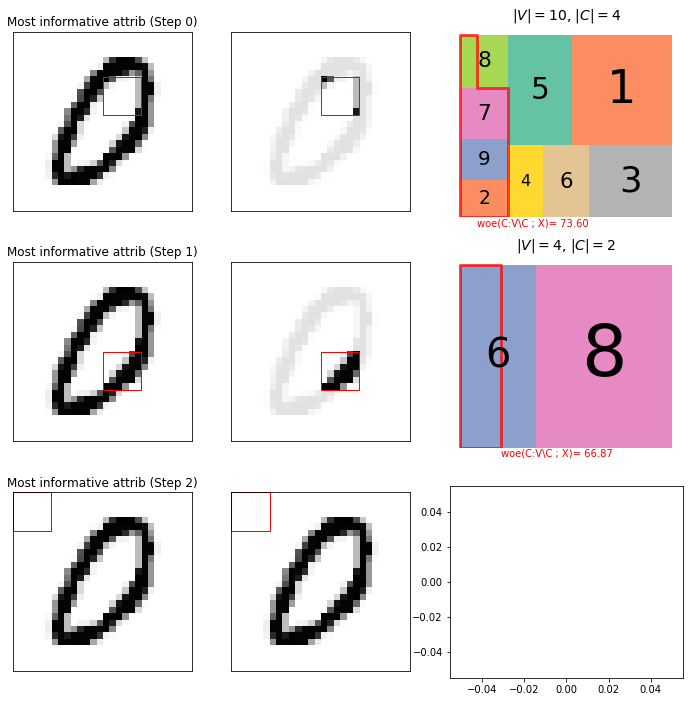

In [15]:
e.plot(plot_type = 'treemap', mask_alpha = 0.2, save_path = save_path)